<center><h1>QBUS6840 - Predictive Analytics - 2024S2</h1></center>

# Tutorial 8 – ARIMA Models (I)
 
### Objectives:

- Understanding stationarity
- Enforce stationarity through differencing
- Interpret ACF/PACF plots
- Understanding Autoregressive (AR) processes

In tutorials 6 and 7, we have learnt the Holt-Winters methods including Simple Exponential Smoothing (SES), Trend corrected ES (TCES) and Holt-Winters seasonal models to smooth time series or to make forecast for future data. In many applications where the time series exhibit trend and seasonal patterns clearly, these models are commonly used due to some advantages such as easy to interpret, estimate and produce reliable forecasting results.

However, there are two major limitations about the Holt-Winters methods: 
- First, these methods produce forecasts that lag the actual observations. 
- Second, Holt-Winters methods are best used for forecasts that are short-term and in the absence of cyclical or residual variations. As a result, forecasts aren't accurate when data with cyclical or residual variations are present. In these types of data, the averaging approaches such as Holt-Winters model normally won't work very well.

In order to address the above issues, in Week 8 and Week 9 tutorial sessions, we will investigate another class of predictive models: the **A**uto**R**egressive **I**ntegrated **M**oving **A**verage, e.g. $ARIMA(p,d,q)$, which consists of 3 components:

- **$AR(p)$:** assumes that an observation is linearly related to the one or more past observations, e.g., variable of interest $Y_t$ is regressed on its own lagged values, e.g. $\{Y_{t-1},...,Y_{t-p}\}$.
- **$MA(q)$:** assumes that the $Y_t$ is actually a linear combination of error terms $\varepsilon_{t-1:t-q}$ whose values occurred contemporaneously and at various times in the past.
- **$I(d)$:** indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once, e.g. $d \ge 1$).

**Note:**
- The integrated component **$I(d)$** of the $ARIMA(p,d,q)$ model is to enforce the input data to be stationary by applying the differencing operation to the original data $d$ times. So that the **ARIMA model could handle the non-stationary data.**
- The $AR(p)$, $MA(q)$ and $ARMA(p,q)$ models still require a weakly stationary data as input.
- The ARIMA models are often called Box-Jenkin methods interchangeably. 

In the next three weeks, we will discuss autoregressive integrated moving average (ARIMA) models and how to use them for time series forecasting. They are a combination of autoregressive and moving average models so we will first look at each model. The focus of this week is autoregressive processes $AR(p)$, or the $AR(1)$ process in particular.  

In [ ]:
# Many techniques to time series forecasts
# 1. Decomposition (Moving Averarage, linear regression ...) (Good for interpreation but not good for pactical use)
# 2. Exponential smooothing
        # Simple exponential, Holt's exponenetial smoothing. Holt_winter exponential smoothing
# 3. ARIMA (Not trying decompositions)
# 4. Neural network (NN) (Can't explain everything inside  but get good results, can't say why?)
# 5. Other methods (fourier transformations,, et)

# Decomposition : yt = f(T, c, s, I)
# ARIMA : yt = f(Y1,t-1 , e1,t-1)
        
        
# AR(p) = yt = f(y1:t-p)        
# MA(q) = yt = f(e1:t-q)       
# ARMA(p,q) = yt = f(y1:t-p,e1:t-q )        

# For above three inputs should be stationary data or close to stationary data. Not applicable for non-stationary data
        
# So when the series are non-stationary we use differencing and make them stationary and use ARIMA.
# So ARIMA(p,d,q) can handle non-stationary series. d means how many times you difference the series to make it stationary.
        
# AR(p) yt = c + ......... + et
# This is a random proces so we have the error term.

## 1. Load and visualize data

Create a new Jupyter Notebook called "Tutorial_08.ipynb" and download the ***ComputerSales.csv*** file from Canvas. Let's begin our script by importing necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
import statsmodels.api as smt

Next, read the data from a csv file then plot the data. The time series shows the monthly sale (in $m) of a computer company. 

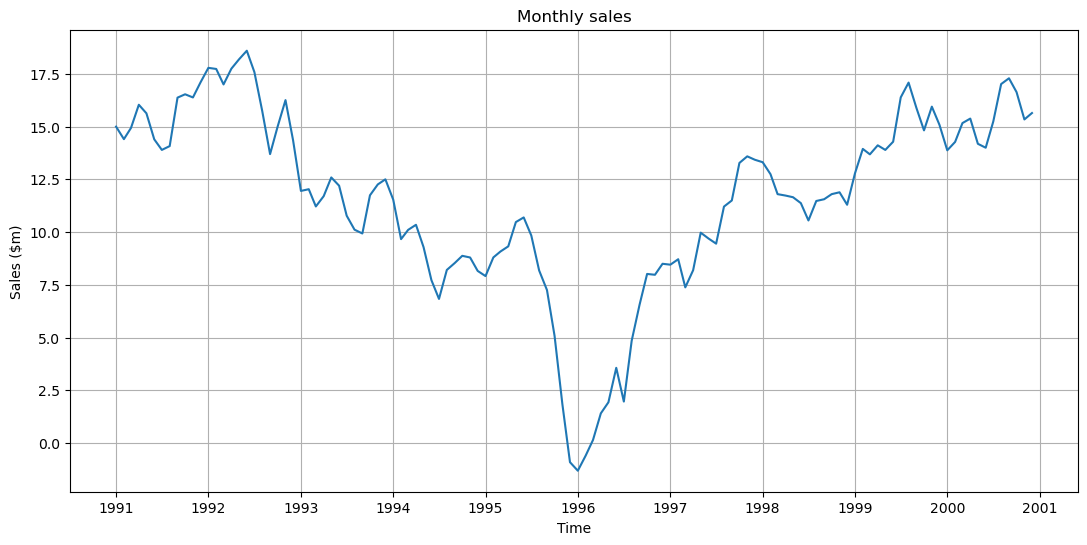

In [2]:
# Then read the data file into a DataFrame object
data = pd.read_csv('ComputerSales.csv')
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.head()

# Extract month sales (in $m)
sales = data['Sale']

# Plot data
plt.figure(figsize=(13,6))
plt.plot(sales.index,sales)
plt.xlabel('Time')
plt.ylabel('Sales ($m)')
plt.title('Monthly sales')
plt.grid()
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Describe the time series. Are the Holt-Winters methods good for this time series?

## 2. Assessing stationarity

The Box-Jenkins methods rely heavily on the concept of stationarity. For example, the $AR(p)$, $MA(q)$ and $ARMA(p,q)$ models require weakly stationary data as input, or we need to examine the stationary of the differenced data to pick the appropriated value of the differencing order $d$ in the $ARIMA(p,d,q)$ model. 

In this tutorial, we are interested in the *weakly* stationary concepts, stating that

***A process ${Y_t}$ is weakly stationary if its mean, variance and covariacne functions do not change over time. That is***

$$
\begin{eqnarray}
\mathbb{E}(Y_t) = \mu \tag{1a}\\
\mathbb{V}(Y_t) = \sigma^2 \tag{1b}\\
\text{Cov}(Y_t,Y_{t-k})=\text{Cov}(Y_t,Y_{t+k}) = \gamma_{k} \tag{1c}
\end{eqnarray}
$$
***for each integer $k$ and for all $t$.***

The key intuition is that an observed time series is often assumed to be a realisation of an underlying stochastic process and by generating from the process, we can get different realisations. The mean, variance, and covariance functions govern the properties across multiple realisations. If the process is stationary, the properties of the observations should not vary with time. Of course, in practice, we only have one realisation (one time series) but we can check stationarity by computing the empirical means, variances and covariances of the time series.
 
**Note:** We use the term **stationary time series** to imply that the (observed) time series is a realisation generated from a **stationary proces**. By definition, the term stationary is only applicable to a *stochastic process*, not a realisation. Deep understanding of stochastic processes is beyond the scope of this unit. For the simplicity, we use the terms **process** and **model** interchangeably in the tutorials (and probably in the lectures!) to describe how data evolve over time. 

In the scope of this unit, the motivation of checking the stationarity of a given time series is to make sure that the selected candidate models are able to simulate well the behavior of the time series and hence produce reasonable forecast values. For example, it is irrelevant to fit a non-stationary time series (realisations), e.g. time series with trend or seasonality, on a stationary $AR(1)$ process (why?). 

There are useful ways to examine the stationarity of a given time series:
- **Visualisation:**
    - We can assess the stationarity of a time series by assessing its **sample ACF** plot. In general, it can be shown that for nonseasonal time series:
        - If the sample ACF of a nonseasonal time series **cuts off or dies down reasonably quickly**, then the time series should be considered it stationary.
        - If the sample ACF of a nonseasonal time series **dies down extremely slowly or not at all**, then the time series should be considered it nonstationary.
    - If the time series exhibit clear trend or seasonality, it is non-stationary (why?).
- **Hypothesis testing:** For example, we can perform the Dickey-Fuller test discussion in the optional section to test the null hypothesis saying that the given time series is stationary.

For example, let's generate the sample ACF plot of the sales data using a built-in function of `statsmodels.api`

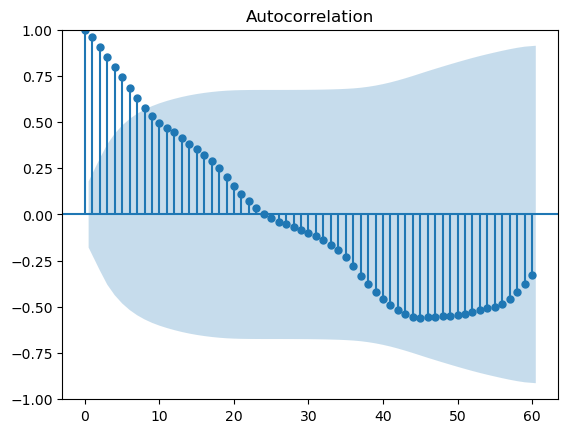

In [4]:
# Plot the sample ACF for the data. This call opens a new plot
smt.graphics.tsa.plot_acf(sales, lags=60, alpha = 0.05)
plt.show()
# ACF dies down extremely slowly or not at all, Non-stationary

Lags defines the number of time-lagging and `alpha = 0.05` defines the confidence interval where the standard deviation is computed according to Bartlett's formula. You can change $0.05$ to other values (i.e. $0.1$) to see what happens.

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Is the `sales` time series stationary? Why?
- Why do we need to plot the confidence interval for the sample ACF?
- What is the difference between ACF and sample ACF?

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


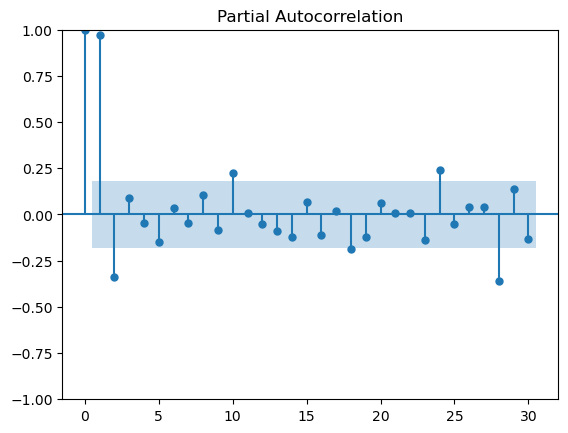

In [5]:
# Plot the PACF for the data. This call opens a new plot
smt.graphics.tsa.plot_pacf(sales, lags=30, alpha=0.05)
plt.show()
# cut off after lag 2 : but peaks at several lags, AR (2)


# Blue area: 95% CI level. Signficance level or threshold value

We can turn a non-stationary time series into stationary by using transforming the data. For example, taking the difference between consecutive observations to form $z_t=Y_{t+1}-Y_t$ for $t=1,2,...,T-1$, could yield a stationary time series. If the sample ACF plot still does not die down quickly enough, we can apply more transformations to the transformed data, for example, by using first-order differencing again.

We can use the `diff()` method of `Series` object to quickly perform the differencing operation on the original time series

In [6]:
# We calculate difference series, Y[1]-Y[0], Y[2]-Y[1],...
sales_diff = pd.Series.diff(sales)
sales_diff

Month
1991-01-01       NaN
1991-02-01   -0.5936
1991-03-01    0.5319
1991-04-01    1.0991
1991-05-01   -0.4054
               ...  
2000-08-01    1.7716
2000-09-01    0.2750
2000-10-01   -0.6563
2000-11-01   -1.2956
2000-12-01    0.3043
Name: Sale, Length: 120, dtype: float64

In [9]:

# Checking the first entry in diff_data
sales_diff.iloc[0]

nan

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Why is the first value a NaN?

Let's remove the NaN and plot the data

In [7]:
# Discard the nan value
sales_diff = sales_diff.dropna()
sales_diff

Month
1991-02-01   -0.5936
1991-03-01    0.5319
1991-04-01    1.0991
1991-05-01   -0.4054
1991-06-01   -1.2345
               ...  
2000-08-01    1.7716
2000-09-01    0.2750
2000-10-01   -0.6563
2000-11-01   -1.2956
2000-12-01    0.3043
Name: Sale, Length: 119, dtype: float64

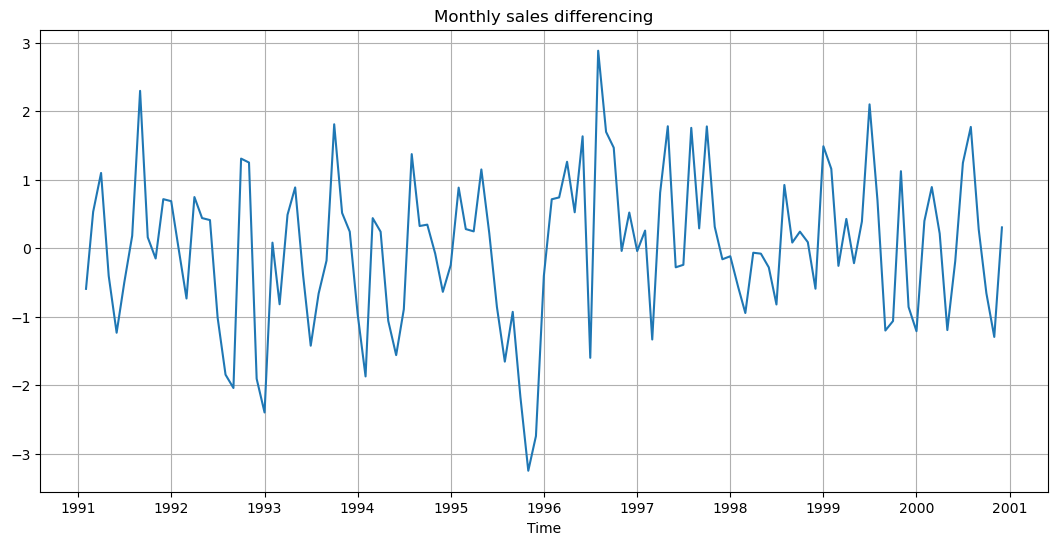

In [8]:

# Plot the differenced data
plt.figure(figsize=(13,6))
plt.plot(sales_diff)
plt.xlabel('Time')
plt.title('Monthly sales differencing')
plt.grid()
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Plot the sample ACF for the differenced series. Is the data now stationary?

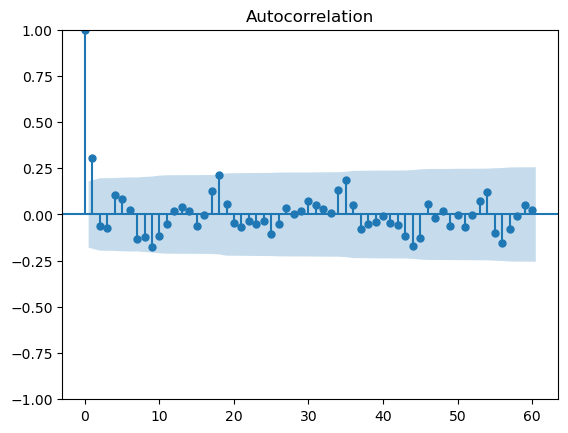

In [9]:
smt.graphics.tsa.plot_acf(sales_diff, lags=60, alpha = 0.05)
plt.show()

## 3. AR (1) process

Mathematically, a general $AR(p)$ model, or $AR(p)$ process, with $p$-th order is defined as:

$$
\begin{eqnarray}
Y_t &=& c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \varepsilon_t \\
 &=& c + \sum_{i=1}^p \phi_i Y_{t-i}+ \varepsilon_t
\end{eqnarray}
\tag{2}
$$

where $c$ is a constant, $\phi_1,...,\phi_p$ are the parameters of the model and $\varepsilon_t$ is white noise, e.g., $\varepsilon_t \sim N(0,\sigma^2_\varepsilon)$. The model in (2) is similar to multiple linear regression where the predictors are one or more past observations. It turns out this simple model can perform really well in practice.


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation - AR(p) </h3></div>

https://otexts.com/fpp2/AR.html


The $AR(1)$ process is then can be derived as

$$
Y_t = c + \phi_1 Y_{t-1} + \varepsilon_t, \;\;\; \varepsilon_t \sim N(0,\sigma^2_\varepsilon) \\
\tag{3}
$$

For an $AR(p)$ model, some parameter constraints are necessary for the model to secure a weak stationarity. More specifically, the $AR(1)$ process is weakly stationary if $|\phi_1| < 1$.

Selecting a suitable order value $p$ can be tricky. A useful way is to observe the ***sample PACF plot*** to find out the cutting off value and use that value as the order for the $AR(p)$ model. The partial autocorrelation of an $AR(p)$ process equates to zero or statistically insignificance level at lag which is bigger than order of $p$. Therefore, the appropriate maximum lag is the one beyond which the partial autocorrelations are all zero or statistically insignificant. Please check the lecture slides for the comprehensive discussion on this topic.

For example, we can quickly examine the sample PACF plot the differenced time series, which is assumed to be stationary (check the sample ACF). 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


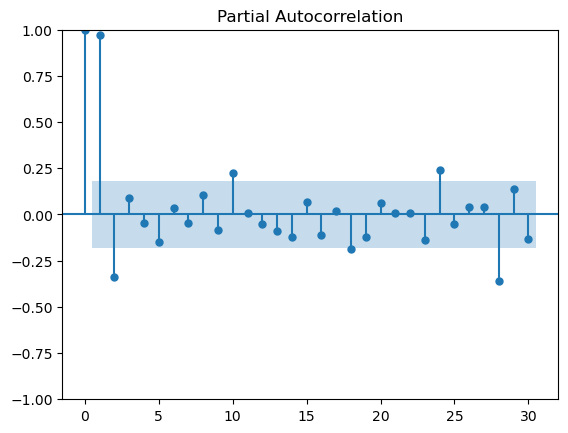

In [10]:
# Plot the sample PACF for the data. This call opens a new plot
smt.graphics.tsa.plot_pacf(sales, lags=30, alpha = 0.05)
plt.show()

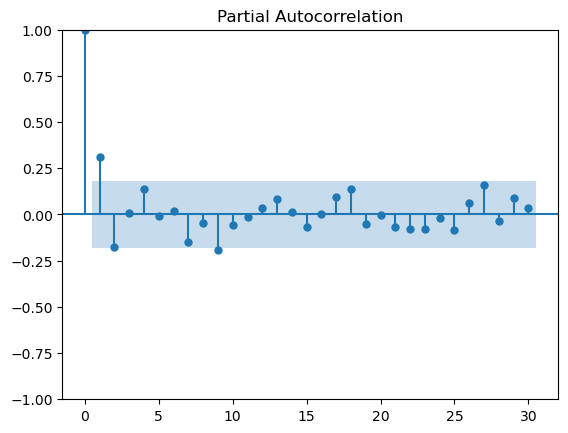

In [11]:
# Plot the sample PACF for the data. This call opens a new plot
smt.graphics.tsa.plot_pacf(sales_diff, lags=30, alpha = 0.05)
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What could be the good value for $p$ if we want to use a $AR(p)$ model for this time series?
- What is the main different between ACF and PACF?

In the next example, let's generate a realisation from a stationary $AR(1)$ process. Normally this step is useful to quickly examine important properties of any particular stochastic processes. `Statsmodels` provides functions to generate samples from $AR(p)$ processes and hence $AR(1)$ processes. We will generate a sample series of $T=250$ data points from the a $AR(1)$ process defined as:

$$
Y_t = 0 + 0.9 Y_{t-1} + \varepsilon_t, \;\;\;\; \varepsilon_t \sim \mathcal{N}(0,1)
\tag{4}
$$

Please read the comments carefully for the explanation of the Python implementation.

In [13]:
# Setting up the random seed
np.random.seed(1)

# Set up the parameters for the AR(1) process
arparams = np.array([0.9]) # Have to be a numpy array
zero_lag = np.array([1])   # For MA component
ar = np.r_[1, -arparams]   # Add zero-lag (coefficient 1)
c = 0                      # Constant term in the AR(1) equation

# Generate a time series from the AR(1) process Yt = c + 0.9Y_{t-1} + e_t
y = c + sm.tsa.arima_process.arma_generate_sample(ar = ar, ma = zero_lag, nsample = 250000)



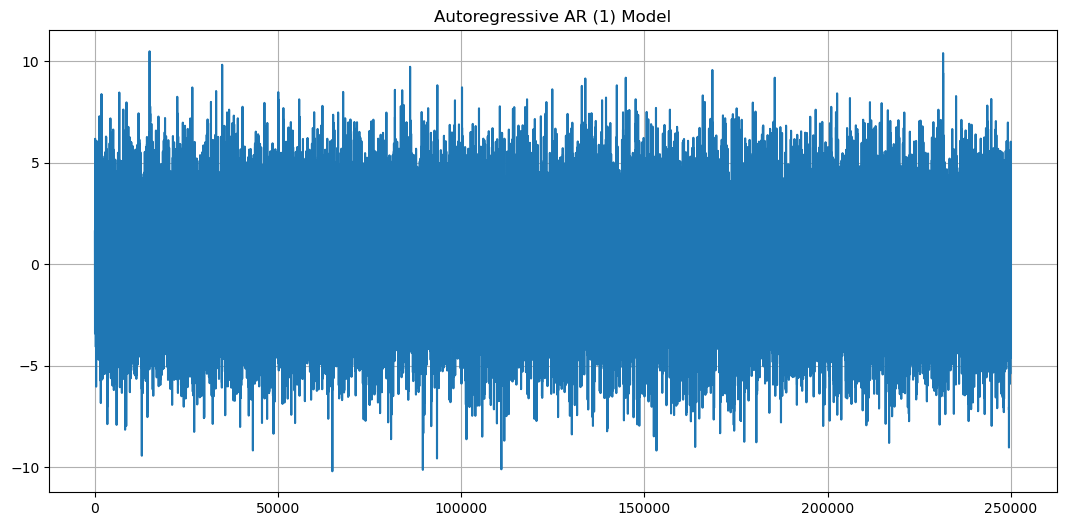

In [19]:
# Plot the time series
plt.figure(figsize=(13,6))
plt.plot(y)
plt.title("Autoregressive AR (1) Model")
plt.grid()
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Think about why we add `–` in front of `arparams`?
- Why do we need to set the random seed?
- What does `ma = zero_lag` mean? **Hint:** A nice interpretation of the `zero_lag` term in the ARMA model (https://stats.stackexchange.com/questions/255206/zero-lag-for-arma-model)

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation - arma_generate_sample() </h3></div>

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_process.arma_generate_sample.html

### 3.1. Inspect the ACF and PACF of the AR(1) process

In the previous sections, we have learnt that the sample ACF plot is used to access the stationarity of a give time series while the sample PACF plot is useful to select the order $p$ for $AR(p)$ model. Now let's visualize the sample ACF and PACF plots of the realisation we have generated from the $AR(1)$ model in (4).

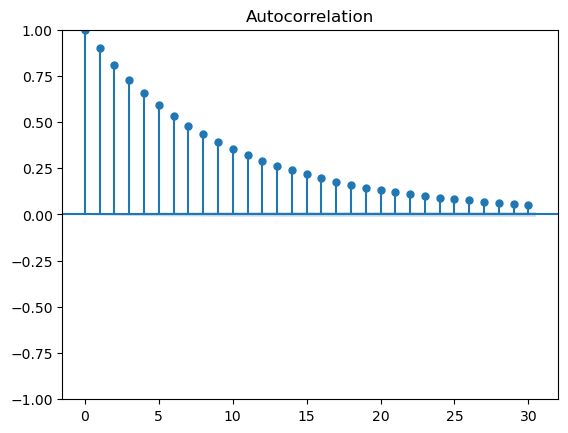

In [15]:
# Examine the ACF and PACF plots
smt.graphics.tsa.plot_acf(y, lags=30, alpha = 0.05)
plt.show()

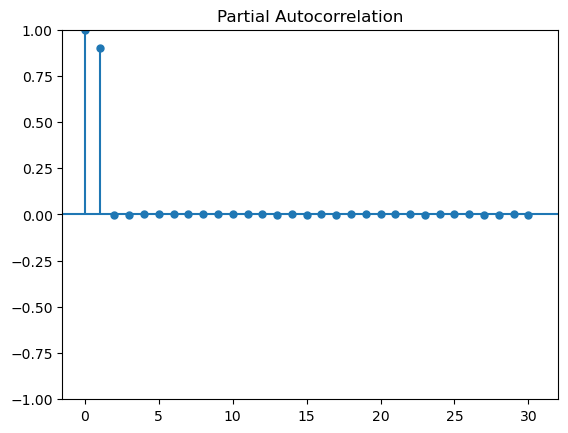

In [21]:
# Because this is an AR model of lag 1, the PACF dies out after lag 1
smt.graphics.tsa.plot_pacf(y, lags=30, alpha = 0.05)
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Check out the PACF plot, when does the plot cuts out?
- Does the ACF plot dies down eventually?

### 3.2. Calculate unconditional mean and unconditional variance of the AR(1) process

We can use the equation below to calculate the unconditional mean of the AR(1) process:

$$E(Y_t) = \frac{c}{1-\phi_1}$$

and compare the unconditional mean to the sample mean, which is the average of all data points in the sample series

In [16]:
# Calculate unconditional mean
y_uncond_mean = c / (1 - arparams[0])
print(y_uncond_mean)

# Calculate sample mean
sample_mean = np.mean(y)
print(sample_mean)
# IF the samples size is large enough these nos should be similar
# when sample y size is 2.5 million mean is 0.0002035459592676515
# when sample y size is 250 mean is 0.802054273

0.0
0.03200084825522697


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Compare the unconditional mean and sample mean, what do you observe? Why? 
- If we keep increasing the sample size of the sample time series, what will happen? 

To calculate the unconditional variance, use the following equation:

$$
Var(Y_t) = \frac{\sigma_\varepsilon^2}{1-\phi_1^2}
$$

`arma_generate_sample` uses `np.random.randn` to generate $\varepsilon$. Therefore, we know that by default $Var(\varepsilon) = \sigma_\varepsilon^2$ and $E(\varepsilon) = 0$. By default, $\sigma_\varepsilon^2 = 1$. 

In [17]:
# Calculate unconditional variance
sigma2 = 1
y_uncond_var = sigma2 / (1 - np.power(arparams[0],2))
print(y_uncond_var)

# Calculate sample variance
sample_var = np.var(y)
print(sample_var)

5.263157894736843
5.286467809853523


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Let's increase the sample size to 2,500,000 or more and re-calculate the sample mean and sample variance. What could you observe?

## 5. Checking the stationarity using Dickey-Fuller test (Optional)

In step 3, we have learnt how to check the stationarity by observing the plot. However, for some complicated situations, you may not be able to easily examine if the data is stationary. Therefore, many people prefer to use Dickey-fuller Test to check the stationarity. 

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation - Dickey-fuller Test  </h3></div>

https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test

https://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/

First we consider the null hypothesis $H_0$: the time series is non-stationary. The result from the rest will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary (the force is strong with this one !!). Alternatively, we can check the p-value of the test to make the decision of rejecting the null hypothesis $H_0$ or not.

We can use the `adfuller` function from `statsmodels` module to quickly perform the Dickey-fuller Test

In [18]:
from statsmodels.tsa.stattools import adfuller

# Check the stationarity using a statistical test
#  H0 : Time series is non-sationary vs H1: Time series is stationary

# check the stationary (advanced)

# Check the stationarity using a statistical test
#  H0 : Time series is non-sationary vs H1: Time series is stationary


Then, we write a `test_stationarity()` function. This `test_stationarity()` will call the Dickey-fuller Test and print out the test results. For convenience, we also create a `plot_curve()` function to plot for visualization. This `plot_curve()` function will input the time series data and generate the rolling mean and rolling standard deviation curve:

In [19]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    # Print test outputs
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','pvalue','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def plot_curve(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12,center=True).mean()
    rolstd = timeseries.rolling(12,center=True).std()

    # Plot rolling statistics:
    plt.figure(figsize=(13,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid()
    plt.show()

When you finish defining these functions, please remember to call these unctions with following statement (otherwise, the above statements will never be executed!!!). Now, let's use the Dickey-fuller Test method to check the stationarity of the original data:

Results of Dickey-Fuller Test:
Test Statistic                  -1.813623
pvalue                           0.373720
#Lags Used                       1.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


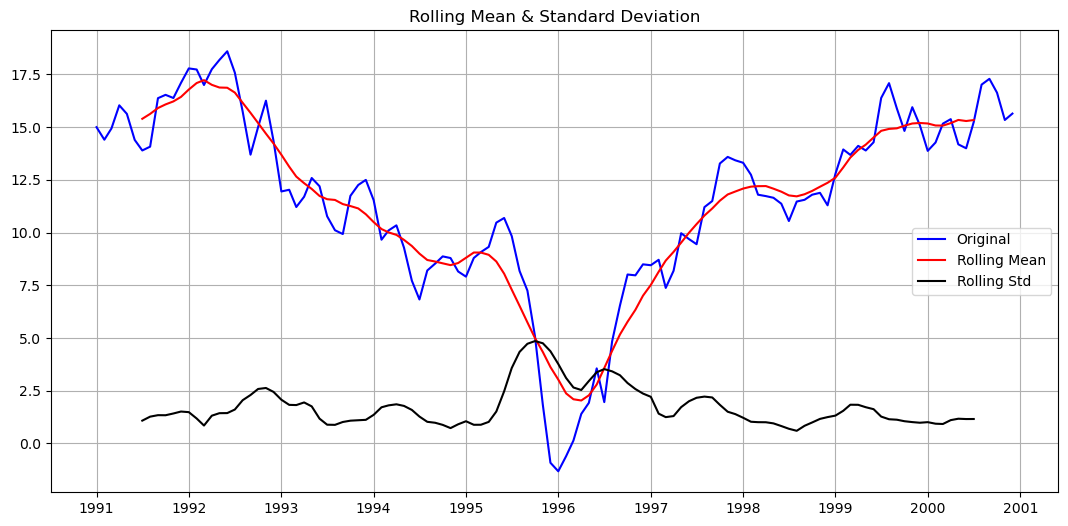

In [20]:
# Call test_stationarity() function to perform Dickey-Fuller test for the original series
test_stationarity(sales)   

# Then call the plot_curve() to visualize the original, rolling mean and rolling std series
plot_curve(sales)

# H0 : Time series is non-sationary vs H1: Time series is stationary
# P value > 0.05, we do not reject H0: (Non - stationary)
# test stat with critical value (0.05)

#  H0 : Time series is non-sationary vs H1: Time series is stationary

Please pay attention to the above plot and test results. Clearly, this is not stationary because:
- Rolling mean is increasing even though the std is small.
- The p-value is 0.37, which is higher than significant levels at 1%, 5% and 10% then we do not reject the $H_0$, which states that the given time series is non-stationary. 

Now you could call the `test_stationarity()` and `plot_curve()` function to test the stationarity of `ts_res` in Section 4.

Results of Dickey-Fuller Test:
Test Statistic                -7.514841e+00
pvalue                         3.928055e-11
#Lags Used                     1.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


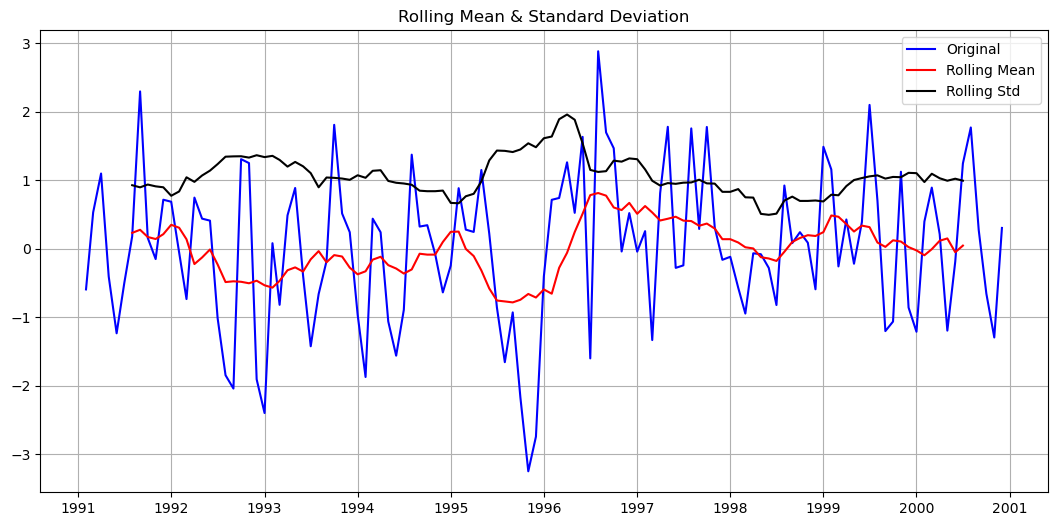

In [21]:
# Call test_stationarity() function to perform Dickey-Fuller test for the de-trended series
test_stationarity(sales_diff)   

# Then call the plot_curve() to visualize the original, rolling mean and rolling std series
plot_curve(sales_diff)

#  H0 : Time series is non-sationary vs H1: Time series is stationary
# P value < 0.05, we reject H0: : series is stationary

From the above outputs, you can see the current time series data is stationary because:
- The rolling values are varying slightly but there is no specific trend
- The p-value is $3.92 \times 10^{-11}$, which is smaller than significant levels at 1% then we reject the $H_0$ at significant level 1%.

**Note:** Much of this optional section is adopted from this article

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introductionusing-python-414fcb963000

# Task

There will be no tutorial tasks for this week